In [ ]:
from gptopt.optim.attn_kq import *
from tests.lp_cupdlpx import *
from utils_pdhg import *
from gptopt.optim.least_squares import * 

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )  
\end{aligned}
$$


In [3]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.01
rank_ratio = 0.7
max_iter = 1000

betas = [ 1e-3, 5e-4, 1e-4]

#  $m=n=75$

In [ ]:
m = n = 75
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)
beta = 0.05
mu_reg = 0
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5

print(f"{lamb_max=:.4e}")

In [5]:
Z_star_1, Z_star_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg, verbose=False)

In [6]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

In [7]:
func_obj = lambda Z1, Z2: (torch.trace(G1.T @ Z1) + torch.trace(G2.T @ Z2)).item()  
func_constr_viol = lambda Z1, Z2: max(torch.max(torch.abs(Z1.T @ B + A.T @ Z2)).item() - beta, 0) / beta

In [8]:
print(
    f"{f_star=:.4e}, "
    f"{func_obj(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}, "
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}"
)
print(pd_residuals_infty_ball(A=A, B=B, Y=torch.from_numpy(Y_star).to(G1.dtype).to(G1.device), 
                              Z1=torch.from_numpy(Z_star_1).to(G1.dtype).to(G1.device), 
                              Z2=torch.from_numpy(Z_star_2).to(G1.dtype).to(G1.device), 
                                      G1=G1, G2=G2, beta=beta, mu=0, abs_tol=1e-4))

f_star=-3.7663e-02, -0.03766261786222458, 
cvxpy constraint violation: 2.3841857904605135e-07
(6.915864069014788e-05, 1.8442304184039435e-05, 1.0807755256655296e-10, 9.233264986175607e-09)


In [9]:
Z_star_12, Z_star_22, f_star2, Y_star2 = cupdlpx_AB(
    G1, G2, A, B, beta,
    time_limit=180, iter_limit=100000,
    eps_feas=1e-7, eps_opt=1e-7,
    feasibility_polishing=True, eps_feas_polish=1e-8
) 
print(
    f"{f_star2=:.4e}, "
    f"{func_obj(Z_star_12, Z_star_22)}, "
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(Z_star_12, Z_star_22)}"
)
print(pd_residuals_infty_ball(A=A, B=B, Y=Y_star2, Z1=Z_star_12, Z2=Z_star_22, 
                                      G1=G1, G2=G2, beta=beta, mu=0, abs_tol=1e-4))

Feasibility Polishing Summary
  Primal Status        : FEAS_POLISH_SUCCESS
  Primal Iterations    : 100
  Primal Time Usage    : 0.00889 sec
  Dual Status          : FEAS_POLISH_SUCCESS
  Dual Iterations      : 0
  Dual Time Usage      : 0.000163 sec
  Primal Residual      : 9.354e-07
  Dual Residual        : 2.352e-09
  Primal Dual Gap      : 3.343e-09
Solution Summary
  Status             : OPTIMAL
  Solve time         : 0.238 sec
  Iterations         : 2700
  Primal objective   : -0.03766176761
  Dual objective     : -0.03766176401
  Objective gap      : 3.343e-09
  Primal infeas      : 9.354e-07
  Dual infeas        : 2.352e-09
f_star2=-3.7662e-02, -0.03766176849603653, 
cvxpy constraint violation: 1.1324882506769107e-06
(0.0001697480445727706, 4.5266145219405494e-05, 4.1951844968252776e-10, 3.5840236205599524e-08)


In [10]:
residuals_cold_start = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, beta=beta, mu_reg=mu_reg, f_star=f_star, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-5)

Y0, _ = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=100) 
(Z1_0, Z2_0), _ = attn_least_squares_solve(A1=B, A2=A, G1=G1, G2=G2, X_type="Z", Y0=Y0, beta=beta, 
                                              tol=1e-10, maxit=100, diag_scaling=True)
r1, r1_rel, r2, r2_rel = pd_residuals_max_ball(B, A, Y0, torch.cat([Z1_0, Z2_0], dim=0), G1, G2, beta, mu=0, abs_tol=1e-4)
print(f"init {r1_rel=:.4e}, {r2_rel=:.4e}")   
residuals_warm_start = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, Z1_0=Z1_0, Z2_0=Z2_0, Y0=Y0,
                                        beta=beta, mu_reg=mu_reg, f_star=f_star, stopping=False, max_iter=max_iter, eps_abs=1e-5)

Feasibility Polishing Summary
  Primal Status        : FEAS_POLISH_SUCCESS
  Primal Iterations    : 100
  Primal Time Usage    : 0.00885 sec
  Dual Status          : FEAS_POLISH_SUCCESS
  Dual Iterations      : 0
  Dual Time Usage      : 0.000151 sec
  Primal Residual      : 9.354e-07
  Dual Residual        : 2.352e-09
  Primal Dual Gap      : 3.343e-09
Solution Summary
  Status             : OPTIMAL
  Solve time         : 0.237 sec
  Iterations         : 2700
  Primal objective   : -0.03766176757
  Dual objective     : -0.03766176397
  Objective gap      : 3.343e-09
  Primal infeas      : 9.354e-07
  Dual infeas        : 2.352e-09
f_star2=-0.03766176756965347, f_star=np.float64(-0.03766261502489701)
Method                 Obj          Viol
----------------------------------------
pdhg          -1.606390e-06  0.000000e+00
rehpdhg       -1.606390e-06  0.000000e+00
pdhg ds       -2.811832e-06  0.000000e+00
rehpdhg ds    -2.811832e-06  0.000000e+00
ada rehpdhg   -1.606390e-06  0.000000e+0

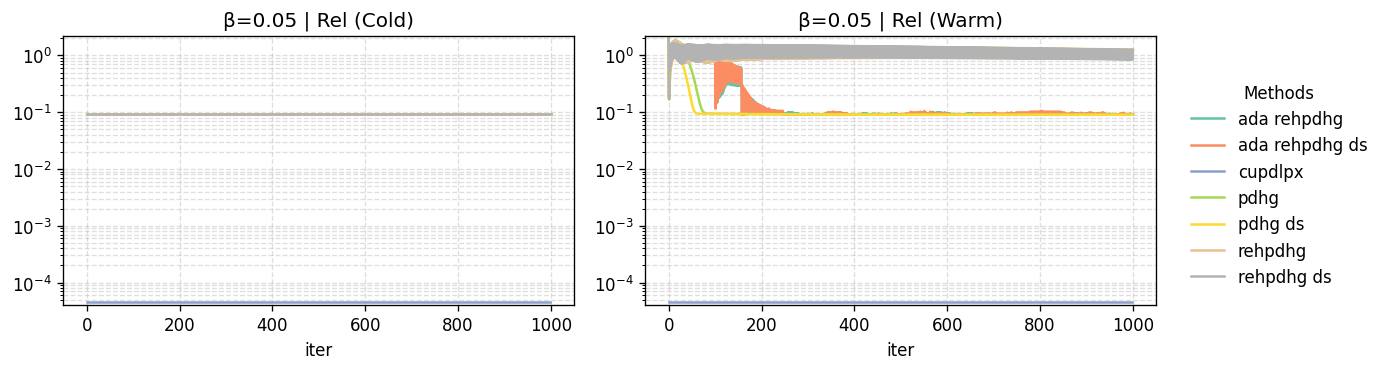

In [11]:
_ = plot_residuals_cold_warm_grid_by_param(
    {beta:residuals_cold_start},
    {beta:residuals_warm_start},
    param_name="beta", 
    dpi=120, 
)

#  $m=n=1000$

In [12]:
m = n = 1000
std2 = 1 
rank_ratio = 0.5
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)

lamb_max = (A.pow(2).sum().sqrt().item() + B.pow(2).sum().sqrt().item()) ** 0.5

print(f"{lamb_max=:.4e}")

lamb_max=3.7620e+00


In [13]:
residuals_cold_start, residuals_warm_start = {}, {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}") 
    residuals_cold_start[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, beta=beta, mu_reg=mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-5)

    Y0, _ = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=100) 
    (Z1_0, Z2_0), _ = attn_least_squares_solve(A1=B, A2=A, G1=G1, G2=G2, X_type="Z", Y0=Y0, beta=beta, 
                                                tol=1e-10, maxit=100, diag_scaling=True)
    r1, r1_rel, r2, r2_rel = pd_residuals_max_ball(B, A, Y0, torch.cat([Z1_0, Z2_0], dim=0), G1, G2, beta, mu=0, abs_tol=1e-4)
    print(f"init {r1_rel=:.4e}, {r2_rel=:.4e}")
    residuals_warm_start[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, Z1_0=Z1_0, Z2_0=Z2_0, Y0=Y0,
                                            beta=beta, mu_reg=mu_reg, f_star=None, stopping=False, max_iter=max_iter, eps_abs=1e-5, theta=1)

beta=0.001, lamb_max=3.7620e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -9.731257e-01  4.177142e-01
rehpdhg       -9.806091e-01  6.203114e-02
pdhg ds       -9.849908e-01  3.782780e-01
rehpdhg ds    -9.931808e-01  6.013461e-02
ada rehpdhg   -9.642490e-01  5.802657e-02
ada rehpdhg ds  -9.767851e-01  5.132046e-02
init r1_rel=1.9998e+00, r2_rel=3.1066e-04
Method                 Obj          Viol
----------------------------------------
init          1.000175e+00  6.463744e-02
pdhg          -9.031098e-01  4.587042e-01
rehpdhg       -8.898623e-01  9.747821e-02
pdhg ds       -9.460790e-01  5.880978e-01
rehpdhg ds    -9.359744e-01  9.395897e-02
ada rehpdhg   -8.472672e-01  9.050109e-02
ada rehpdhg ds  -9.006307e-01  7.276486e-02
beta=0.0005, lamb_max=3.7620e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -4.933634e-01  7.243566e-01
rehpdhg       -5.008973e-01  8.108122e-02
pdhg ds       

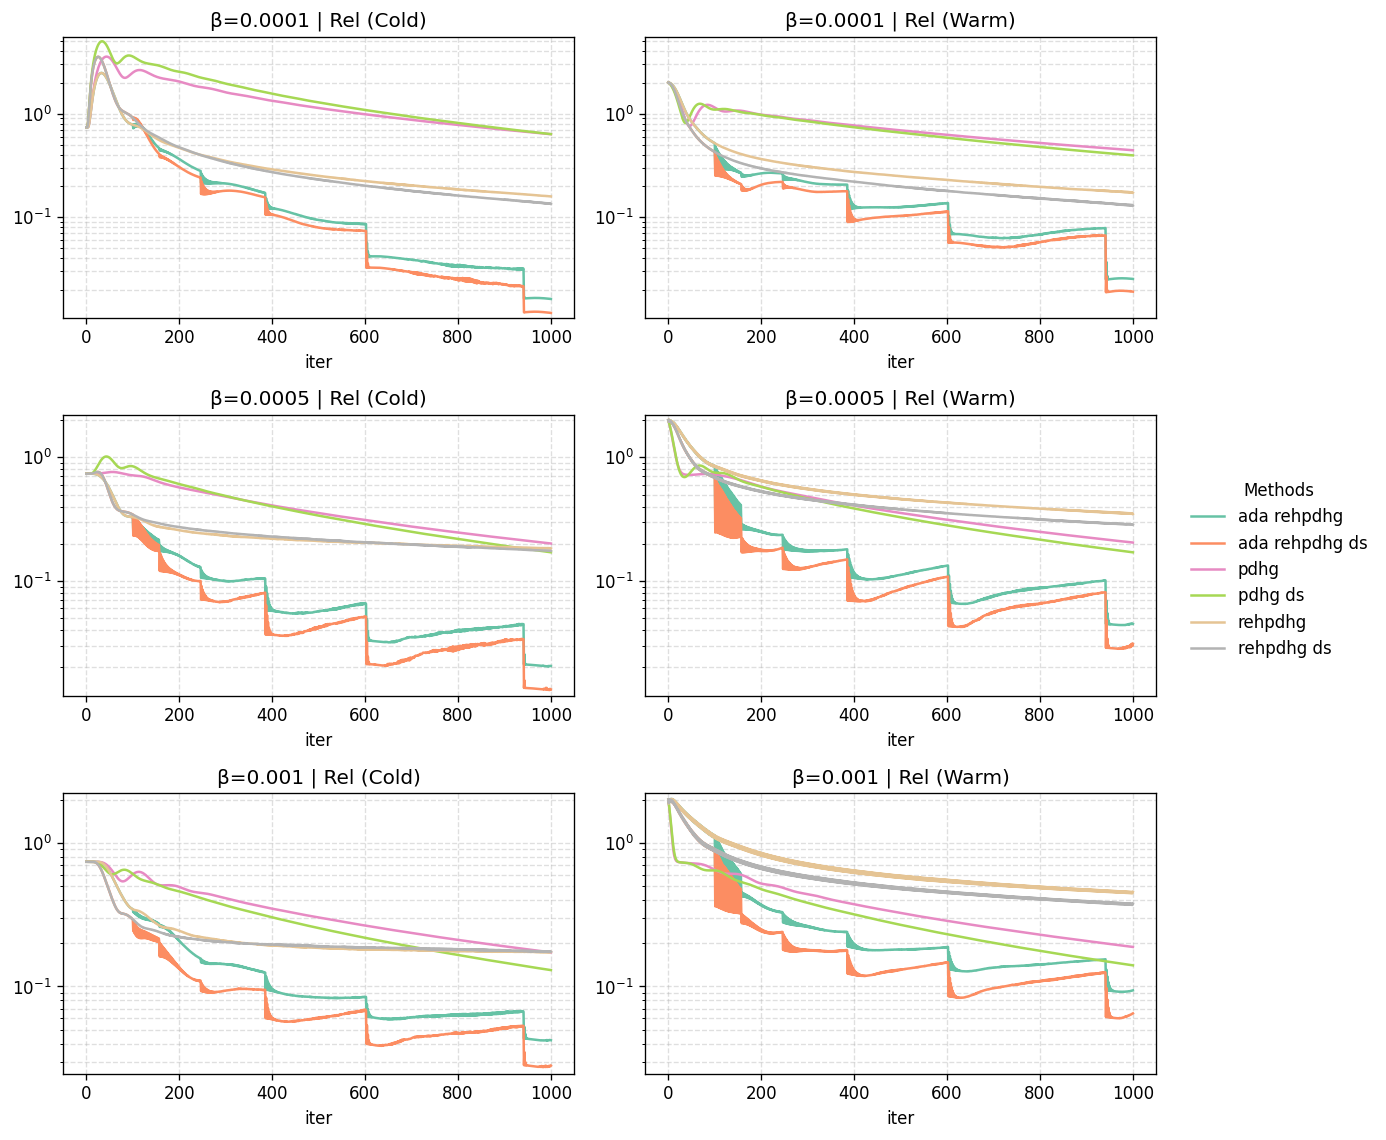

In [14]:
_ = plot_residuals_cold_warm_grid_by_param(
    residuals_cold_start,
    residuals_warm_start,
    param_name="beta", 
    dpi=120, 
)

#  $m=n=1000$

In [15]:
m = n = 1000
std2 = 0.1
rank_ratio = 0.5
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)


nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{mu_reg=:.4e}, {lamb_max=:.4e}")

mu_reg=0.0000e+00, lamb_max=9.9973e+00


In [16]:
residuals_cold_start, residuals_warm_start = {}, {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}") 
    residuals_cold_start[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, beta=beta, mu_reg=mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-5)

    Y0, _ = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=100) 
    (Z1_0, Z2_0), _ = attn_least_squares_solve(A1=B, A2=A, G1=G1, G2=G2, X_type="Z", Y0=Y0, beta=beta, 
                                                tol=1e-10, maxit=100, diag_scaling=True)
    r1, r1_rel, r2, r2_rel = pd_residuals_max_ball(B, A, Y0, torch.cat([Z1_0, Z2_0], dim=0), G1, G2, beta, mu=0, abs_tol=1e-4)
    print(f"init {r1=:.4e}, {r2=:.4e}, {r1_rel=:.4e}, {r2_rel=:.4e}")
    residuals_warm_start[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, Z1_0=Z1_0, Z2_0=Z2_0, Y0=Y0,
                                            beta=beta, mu_reg=mu_reg, f_star=None, stopping=False, max_iter=max_iter, eps_abs=1e-5)
    

beta=0.001, lamb_max=9.9973e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -7.856937e-02  9.617785e-02
rehpdhg       -7.819445e-02  3.266758e-02
pdhg ds       -8.686211e-02  9.901302e-02
rehpdhg ds    -8.693187e-02  4.146311e-02
ada rehpdhg   -5.969892e-02  2.533353e-02
ada rehpdhg ds  -7.544692e-02  2.210790e-02
init r1=1.9993e+00, r2=1.6475e-05, r1_rel=1.9993e+00, r2_rel=9.0994e-05
Method                 Obj          Viol
----------------------------------------
init          1.000198e-01  6.342207e-02
pdhg          -1.996091e-02  1.211948e-01
rehpdhg       -1.967796e-02  4.746874e-02
pdhg ds       -4.932224e-02  1.189791e-01
rehpdhg ds    -4.873764e-02  4.357011e-02
ada rehpdhg   6.074948e-02  1.767660e-04
ada rehpdhg ds  3.375674e-02  3.225769e-02
beta=0.0005, lamb_max=9.9973e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -4.413511e-02  1.306786e-01
rehpdhg       -4.417939e-02 

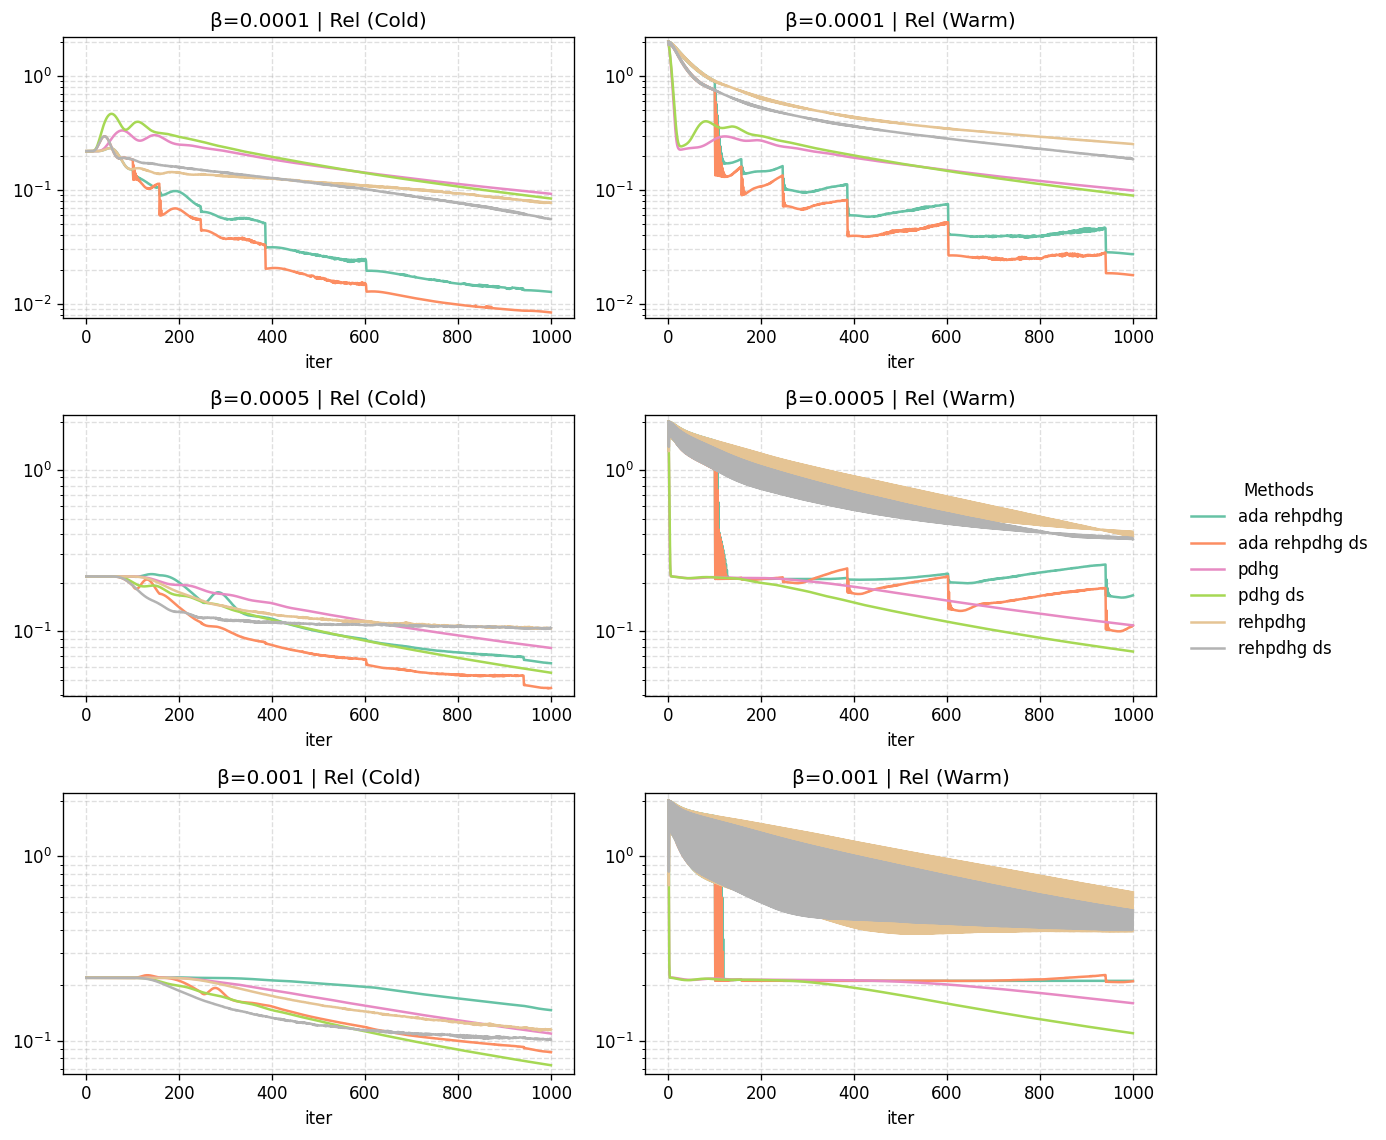

In [17]:
_ = plot_residuals_cold_warm_grid_by_param(
    residuals_cold_start,
    residuals_warm_start,
    param_name="beta", 
    dpi=120, 
)